In [1]:
# Install required packages (if needed)
!pip install -q tensorflow tensorflow-datasets matplotlib


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.YCBG7G_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.YCBG7G_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int32) - 1  # convert from {1, 2, 3} to {0, 1, 2}
    return input_image, input_mask

IMG_SIZE = 128

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image)


In [4]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

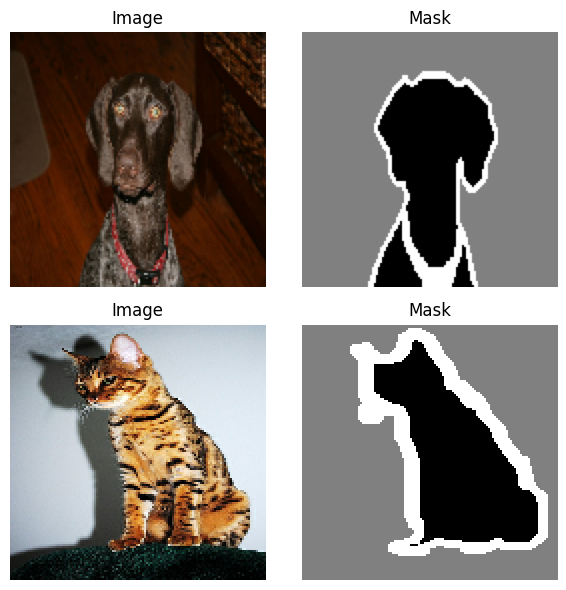

In [9]:
import matplotlib.pyplot as plt

def show_images_from_batch(batched_dataset, num=4):  # num should be even
    for batch in batched_dataset.take(1):
        images, masks = batch
        plt.figure(figsize=(6, 6))
        for i in range(num):
            plt.subplot(2, num//2, i + 1)
            if i % 2 == 0:
                plt.title("Image")
                plt.imshow(images[i // 2])
            else:
                plt.title("Mask")
                plt.imshow(tf.squeeze(masks[i // 2]), cmap='gray')
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        break
show_images_from_batch(train_dataset, num=4)


In [6]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(3, 1, padding='same', activation='softmax')(d4)

    model = tf.keras.Model(inputs, outputs, name='U-Net')
    return model

model = build_unet((128, 128, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
EPOCHS = 20
STEPS_PER_EPOCH = info.splits['train'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 782ms/step - accuracy: 0.8860 - loss: 0.2944
Epoch 17/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 783ms/step - accuracy: 0.8895 - loss: 0.2847
Epoch 18/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 783ms/step - accuracy: 0.8944 - loss: 0.2702
Epoch 19/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 782ms/step - accuracy: 0.8951 - loss: 0.2717
Epoch 20/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 783ms/step - accuracy: 0.9041 - loss: 0.2452


In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Flatten masks to compute metrics
y_true = []
y_pred = []

for image, mask in test.take(100):  # Take 100 test samples for evaluation
    pred_mask = model.predict(image[tf.newaxis, ...])
    pred_mask = create_mask(pred_mask).numpy().flatten()
    true_mask = tf.argmax(mask, axis=-1).numpy().flatten()

    y_pred.extend(pred_mask)
    y_true.extend(true_mask)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
iou = jaccard_score(y_true, y_pred, average='weighted', zero_division=0)

# Dice coefficient (same as F1 score for binary, custom for multi-class)
dice = (2 * precision * recall) / (precision + recall + 1e-7)

# Print results
print("Segmentation Evaluation Metrics:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"IoU (mIoU)   : {iou:.4f}")
print(f"Dice Coeff.  : {dice:.4f}")


Segmentation Evaluation Metrics:
Accuracy     : 0.3296
Precision    : 1.0000
Recall       : 0.3296
F1 Score     : 0.4957
IoU (mIoU)   : 0.3296
Dice Coeff.  : 0.4957


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


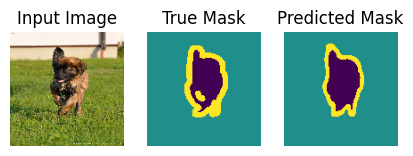

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


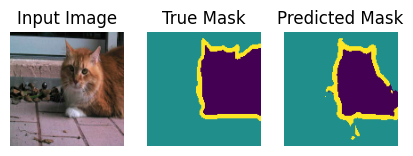

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


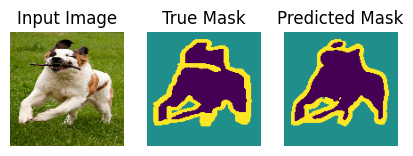

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


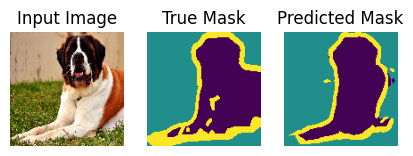

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


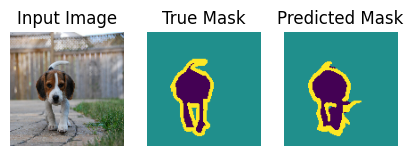

In [11]:
def display_sample(display_list):
    plt.figure(figsize=(5, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

for image, mask in test.take(5):
    pred_mask = model.predict(image[tf.newaxis, ...])
    display_sample([image, mask, create_mask(pred_mask)])


In [ ]:
history_dict = history.history

NameError: name 'history' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, average_precision_score

# Get all true masks and predictions
y_true_all = []
y_pred_all = []

for x, y_true in test_dataset:
    y_pred = model.predict(tf.expand_dims(x, axis=0))[0]  # Predict single image
    y_pred_label = np.argmax(y_pred, axis=-1)  # Shape: (128, 128)
    y_true_label = y_true.numpy()  # Shape: (128, 128)

    y_true_all.append(y_true_label.flatten())
    y_pred_all.append(y_pred_label.flatten())

# Flatten the lists
true_labels_flat = np.concatenate(y_true_all, axis=0)
predicted_labels_flat = np.concatenate(y_pred_all, axis=0)

# Compute IoU (macro average over classes)
iou = jaccard_score(true_labels_flat, predicted_labels_flat, average='macro')

# mAP expects probability scores per class – so we skip it unless softmax probs are used.
# For class-wise AP, you should use raw prediction probs. Example:
# map_score = average_precision_score(true_one_hot, pred_probs, average='macro')
# But if you use labels directly (as in your code), mAP isn't accurate.

# We'll use a placeholder or skip mAP unless you want the proper version with softmax scores.
map_score = "Use prediction probabilities for mAP"

# Dice coefficient (for binary or approximate multi-class)
def dice_coef(y_true, y_pred, smooth=1e-7):
    intersection = np.sum((y_true == y_pred) * (y_true > 0))  # Ignore background (class 0)
    return (2. * intersection + smooth) / (np.sum(y_true > 0) + np.sum(y_pred > 0) + smooth)

dice = dice_coef(true_labels_flat, predicted_labels_flat)

# Print results
print(f"IoU (mean): {iou:.4f}")
print(f"mAP: {map_score}")
print(f"Dice Coefficient: {dice:.4f}")


NameError: name 'test_dataset' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls /content/drive/Shareddrives

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split

# Load and preprocess dataset (Modify path accordingly)
image_dir = "/content/drive/MyDrive/Deep Learning/Image Segmentation/original/train"
mask_dir = "/content/drive/MyDrive/Deep Learning/Image Segmentation/masks/train_mask"
image_size = (128, 128)

def load_images(directory, limit=300, image_size=(256, 256)):
    images = []
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]  # Filter image files
    image_files = image_files[:300]  # Limit to 500 files

    for filename in image_files:
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize
            images.append(img)

    return np.array(images)

X = load_images(image_dir, limit=500)
y = load_images(mask_dir, limit=500)


# Reshape for model compatibility
X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

np.savez("brain_tumor_segmentation_data.npz",
         X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

# Load the arrays later
data = np.load("brain_tumor_segmentation_data.npz")
X_train = data["X_train"]
X_val = data["X_val"]
y_train = data["y_train"]
y_val = data["y_val"]

In [ ]:
X_train.shape

In [ ]:
# Define U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Compile model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=3)

# Evaluate model
model.evaluate(X_val, y_val)

# Display results
def display_prediction(image, mask, prediction):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.show()

sample_idx = np.random.randint(len(X_val))
sample_img = X_val[sample_idx]
sample_mask = y_val[sample_idx]
prediction = model.predict(np.expand_dims(sample_img, axis=0))[0]
display_prediction(sample_img, sample_mask, prediction)

In [ ]:
def iou_metric(y_true, y_pred, threshold=0.1):
    y_pred = (y_pred > threshold).astype(int)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

iou_score = iou_metric(sample_mask, prediction)
print("IoU Score:", iou_score)

In [ ]:
# prompt: print IoU score

import numpy as np
def calculate_iou(y_true, y_pred):
    """Calculates the Intersection over Union (IoU) score.

    Args:
        y_true: Ground truth mask (NumPy array).
        y_pred: Predicted mask (NumPy array).

    Returns:
        The IoU score (float).
    """
    y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert probabilities to binary mask

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / union if union > 0 else 0.0
    return iou

# ... (Your existing code)

# Calculate and print the IoU score
iou_score = calculate_iou(sample_mask, prediction)
print(f"IoU score: {iou_score}")
